<a href="https://colab.research.google.com/github/geporys/ts-project-assignment-hse-2023/blob/main/ExportForecastLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys 
sys.path.append("/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/functions")

In [2]:
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf
from functions.data import get_NIC_from_yFinance, get_nickel_data_from_businessinsider, get_rates, union_data_in_one_df, get_AUDIDR_from_yFinance, get_endog_and_exog
from functions.chart import plot_nick_rate_nic
from functions.model import first_model


In [3]:
test = yf.Ticker("NIC.AX")
test_df = test.history(period="max")
test_df = test_df.asfreq(freq='M', method='ffill').fillna(method='ffill')

In [4]:
test_df = test_df.diff()
test_df = test_df.fillna(0)

In [5]:
# plot_pacf(test_df['Close'], lags=12, method='ywm', title="PACF Nickel Industries")

# plt.savefig('images/PACF Nickel Industries.png', dpi=300)

In [6]:
# plot_acf(test_df['Close'], lags=12,  title="ACF Nickel Industries", alpha=0.1)

# plt.savefig('images/ACF Nickel Industries.png', dpi=300)

In [7]:
currency_df = get_AUDIDR_from_yFinance()

<AxesSubplot: xlabel='Date'>

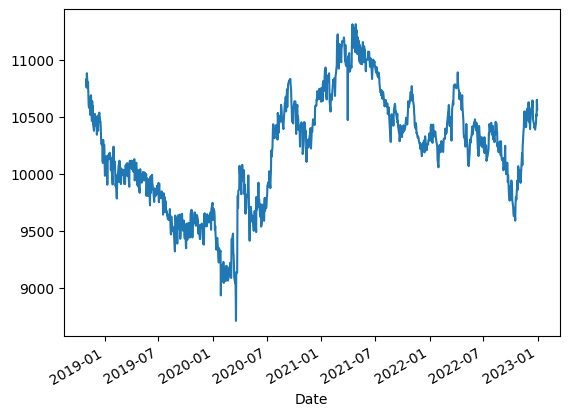

In [8]:
currency_df['Close'].plot()

In [9]:
currency_df.index.normalize()

DatetimeIndex(['2018-10-31 00:00:00+11:00', '2018-11-01 00:00:00+11:00',
               '2018-11-02 00:00:00+11:00', '2018-11-05 00:00:00+11:00',
               '2018-11-06 00:00:00+11:00', '2018-11-07 00:00:00+11:00',
               '2018-11-08 00:00:00+11:00', '2018-11-09 00:00:00+11:00',
               '2018-11-12 00:00:00+11:00', '2018-11-13 00:00:00+11:00',
               ...
               '2022-12-19 00:00:00+11:00', '2022-12-20 00:00:00+11:00',
               '2022-12-21 00:00:00+11:00', '2022-12-22 00:00:00+11:00',
               '2022-12-23 00:00:00+11:00', '2022-12-26 00:00:00+11:00',
               '2022-12-27 00:00:00+11:00', '2022-12-28 00:00:00+11:00',
               '2022-12-29 00:00:00+11:00', '2022-12-30 00:00:00+11:00'],
              dtype='datetime64[ns, Australia/Sydney]', name='Date', length=1088, freq=None)

In [10]:
nic_df = get_NIC_from_yFinance()

In [11]:
nic_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-10-31 00:00:00+11:00,0.243202,0.252209,0.234194,0.247705,640285,0.0,0.0
2018-11-01 00:00:00+11:00,0.247705,0.270224,0.234194,0.243202,1726009,0.0,0.0
2018-11-02 00:00:00+11:00,0.252209,0.252209,0.245003,0.247705,181966,0.0,0.0
2018-11-05 00:00:00+11:00,0.252209,0.256713,0.247705,0.247705,1444336,0.0,0.0
2018-11-06 00:00:00+11:00,0.243202,0.261217,0.238698,0.261217,546481,0.0,0.0
...,...,...,...,...,...,...,...
2022-09-26 00:00:00+10:00,0.779563,0.789369,0.764854,0.779563,15205621,0.0,0.0
2022-09-27 00:00:00+10:00,0.779563,0.794272,0.769757,0.784466,12283210,0.0,0.0
2022-09-28 00:00:00+10:00,0.789369,0.789369,0.745243,0.755049,15720741,0.0,0.0


In [12]:
(nic_df, nickel_df) = get_nickel_data_from_businessinsider(nic_df)

In [13]:
nickel_df[nickel_df['Close'].isnull()]

,Close,Open,High,Low,Volume,Estimate,Date
Date,,,,,,,


In [14]:
rates = get_rates(nic_df)

In [15]:
ind_exp = pd.read_excel("forecasting_ts_project_raw_data/TABEL5_14_volume by sector.xls", sheet_name='5.14', header=4)

In [16]:
ind_exp = ind_exp.transpose().reset_index()

In [17]:
ind_exp_cols = ['Year', 'Month'] + list(ind_exp.iloc[176][2:69]) + ['drop1', 'drop2']
ind_exp.columns = ind_exp_cols

In [18]:
ind_exp = ind_exp[3:174].drop(columns=['drop1', 'drop2'])

In [19]:
bo = ~ind_exp['Year'].str.contains('Unnamed').fillna(False)
ind_exp['Year'] = ind_exp['Year'].where(bo).fillna(method='ffill')

In [20]:
ind_exp = ind_exp[~ind_exp['Month'].isna()]

In [21]:
ind_exp['Month'] = ind_exp['Month'].str.replace('*', '')

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_95327/3288374492.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ind_exp['Month'] = ind_exp['Month'].str.replace('*', '')


In [22]:
ind_exp['Day'] = 1
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
ind_exp.replace({'Month': months}, inplace=True)

In [23]:
dt = pd.to_datetime(ind_exp[['Year', 'Month', 'Day']], format="%Y%m%d")
ind_exp['Date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in dt]

In [24]:
ind_exp.set_index('Date', inplace=True)
ind_exp = ind_exp.asfreq(freq='m', method='ffill').fillna(method='ffill')

In [25]:
ind_exp = ind_exp[['Base metal products', 'Nickel ore']]
ind_exp = ind_exp.asfreq(freq='B').fillna(method='ffill')

# Slice period 
ind_exp = ind_exp['2018-10-31':'2022-09-30']

<AxesSubplot: xlabel='Date'>

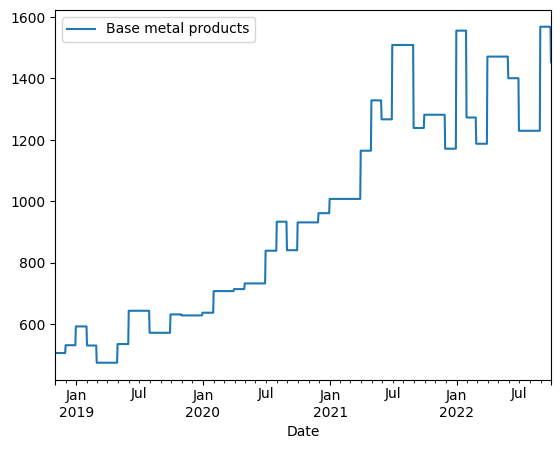

In [26]:
ind_exp.plot()

In [27]:
ind_exp[ind_exp['Base metal products'].isnull()]

,Base metal products,Nickel ore
Date,,


In [28]:
ind_exp

,Base metal products,Nickel ore
Date,,
2018-10-31 00:00:00+11:00,506.75,1968.14
2018-11-01 00:00:00+11:00,506.75,1968.14
2018-11-02 00:00:00+11:00,506.75,1968.14
2018-11-05 00:00:00+11:00,506.75,1968.14
2018-11-06 00:00:00+11:00,506.75,1968.14
...,...,...
2022-09-26 00:00:00+10:00,1568.34,-
2022-09-27 00:00:00+10:00,1568.34,-
2022-09-28 00:00:00+10:00,1568.34,-


In [29]:
mining = pd.DataFrame(data=[
    {'date': '2018-07-01', 'value': 36933},
    {'date': '2018-08-01', 'value': 40904},
    {'date': '2018-09-01', 'value': 48155},
    {'date': '2018-10-01', 'value': 40579},
    {'date': '2018-11-01', 'value': 43322},
    {'date': '2018-12-01', 'value': 39275},
    {'date': '2019-01-01', 'value': 39848},
    {'date': '2019-02-01', 'value': 42772},
    {'date': '2019-03-01', 'value': 44576},
    {'date': '2019-04-01', 'value': 20509},
    {'date': '2019-05-01', 'value': 33281},
    {'date': '2019-06-01', 'value': 24461},
    {'date': '2019-07-01', 'value': 57000},
    {'date': '2019-08-01', 'value': 64000},
    {'date': '2019-09-01', 'value': 77950},
    {'date': '2019-10-01', 'value': 69734},
    {'date': '2019-11-01', 'value': 56086},
    {'date': '2019-12-01', 'value': 68339},
    {'date': '2020-01-01', 'value': 50600},
    {'date': '2020-02-01', 'value': 49666},
    {'date': '2020-03-01', 'value': 49643},
    {'date': '2020-04-01', 'value': 12500},
    {'date': '2020-05-01', 'value': 25400},
    {'date': '2020-06-01', 'value': 24600},
    {'date': '2020-07-01', 'value': 9500},
    {'date': '2020-08-01', 'value': 45900},
    {'date': '2020-09-01', 'value': 102800},
    {'date': '2020-10-01', 'value': 174193},
    {'date': '2020-11-01', 'value': 173930},
    {'date': '2020-12-01', 'value': 151764},
    {'date': '2021-01-01', 'value': 156039},
    {'date': '2021-02-01', 'value': 117728},
    {'date': '2021-03-01', 'value': 182720},
    {'date': '2021-04-01', 'value': 196617},
    {'date': '2021-05-01', 'value': 142056},
    {'date': '2021-06-01', 'value': 236118},
    {'date': '2021-07-01', 'value': 166506},
    {'date': '2021-08-01', 'value': 193068},
    {'date': '2021-09-01', 'value': 219582},
    {'date': '2021-10-01', 'value': 283494},
    {'date': '2021-11-01', 'value': 213090},
    {'date': '2021-12-01', 'value': 313740},
    {'date': '2022-01-01', 'value': 792630/3},
    {'date': '2022-02-01', 'value': 792630/3},
    {'date': '2022-03-01', 'value': 792630/3},
    {'date': '2022-04-01', 'value': 599590/3},
    {'date': '2022-05-01', 'value': 599590/3},
    {'date': '2022-06-01', 'value': 599590/3},
    {'date': '2022-07-01', 'value': 339672},
    {'date': '2022-08-01', 'value': 205722},
    {'date': '2022-09-30', 'value': 301866},
])


mining['date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in mining['date']]


mining = mining.set_index('date')
mining = mining.asfreq(freq='B').fillna(method='ffill')
mining = mining[mining.index >= nic_df.index[0]]

In [30]:
mining[mining['value'].isnull()]

,value
date,


<AxesSubplot: xlabel='date'>

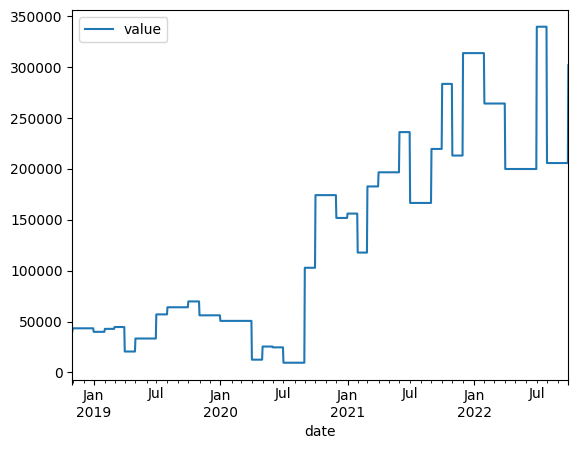

In [31]:
mining.plot()

In [32]:
production = pd.DataFrame(data=[
     {'date': '2018-01-01', 'value': 0},
     {'date': '2018-02-01', 'value': 0},
     {'date': '2018-03-01', 'value': 0},
     {'date': '2018-04-01', 'value': 0},
     {'date': '2018-05-01', 'value': 0},
     {'date': '2018-06-01', 'value': 0},
     {'date': '2018-07-01', 'value': 0},
     {'date': '2018-08-01', 'value': 0},
     {'date': '2018-09-01', 'value': 0},
     {'date': '2018-10-01', 'value': 0},
     {'date': '2018-11-01', 'value': 0},
     {'date': '2018-12-01', 'value': 0},
     {'date': '2019-01-01', 'value': 67.5},
     {'date': '2019-02-01', 'value': 1802},
     {'date': '2019-03-01', 'value': 6502},
     {'date': '2019-04-01', 'value': 8684.8},
     {'date': '2019-05-01', 'value': 11320.5+123.1},
     {'date': '2019-06-01', 'value': 1251.1 + 2354.0},
     {'date': '2019-07-01', 'value': 12700 + 8053},
     {'date': '2019-08-01', 'value': 13405 + 12389},
     {'date': '2019-09-01', 'value': 13451 + 12375},
     {'date': '2019-10-01', 'value': 14937.5 + 13595.3},
     {'date': '2019-11-01', 'value': 12978.0 + 13433.4},
     {'date': '2019-12-01', 'value': 12995.2 + 12076.0},
     {'date': '2020-01-01', 'value': 26858},
     {'date': '2020-02-01', 'value': 25449},
     {'date': '2020-03-01', 'value': 27090},
     {'date': '2020-04-01', 'value': 23179},
     {'date': '2020-05-01', 'value': 24777},
     {'date': '2020-06-01', 'value': 21645},
     {'date': '2020-07-01', 'value': 20768},
     {'date': '2020-08-01', 'value': 23326},
     {'date': '2020-09-01', 'value': 25737},
     {'date': '2020-10-01', 'value': 26068.3},
     {'date': '2020-11-01', 'value': 24542.3},
     {'date': '2020-12-01', 'value': 26456.1},
     {'date': '2021-01-01', 'value': 22170.9},
     {'date': '2021-02-01', 'value': 24497.3},
     {'date': '2021-03-01', 'value': 25271.1},
     {'date': '2021-04-01', 'value': 23991.5},
     {'date': '2021-05-01', 'value': 26383.7},
     {'date': '2021-06-01', 'value': 24111.3},
     {'date': '2021-07-01', 'value': 25146.1},
     {'date': '2021-08-01', 'value': 26305.5},
     {'date': '2021-09-01', 'value': 21702.8},
     {'date': '2021-10-01', 'value': 24589},
     {'date': '2021-11-01', 'value': 26028},
     {'date': '2021-12-01', 'value': 28155}, 
     {'date': '2022-01-01', 'value': 12222 + 12812},
     {'date': '2022-02-01', 'value': 11853 + 11863 + 1939},
     {'date': '2022-03-01', 'value': 12783 + 12556 + 5571 },
     {'date': '2022-04-01', 'value': 114106 / 3},
     {'date': '2022-05-01', 'value': 114106 / 3},
     {'date': '2022-06-01', 'value': 114106 / 3},
     {'date': '2022-07-01', 'value': 145180 / 3},
     {'date': '2022-08-01', 'value': 145180 / 3},
     {'date': '2022-09-30', 'value': 145180 / 3},
])

production['date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in production['date']]


production = production.set_index('date')
production = production.asfreq(freq='B').fillna(method='ffill')
production = production[production.index >= nic_df.index[0]]

In [33]:
production[production['value'].isnull()]

,value
date,


<AxesSubplot: xlabel='date'>

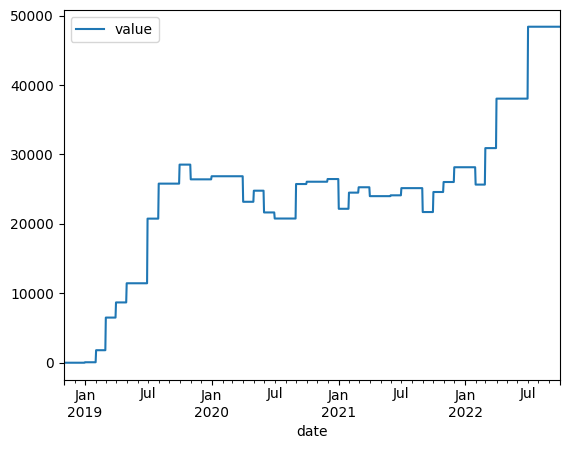

In [34]:
production.plot()

In [35]:
rates

,rate
date,
2018-10-31 00:00:00+11:00,1.50
2018-11-01 00:00:00+11:00,1.50
2018-11-02 00:00:00+11:00,1.50
2018-11-05 00:00:00+11:00,1.50
2018-11-06 00:00:00+11:00,1.50
...,...
2022-09-26 00:00:00+10:00,2.35
2022-09-27 00:00:00+10:00,2.35
2022-09-28 00:00:00+10:00,2.35


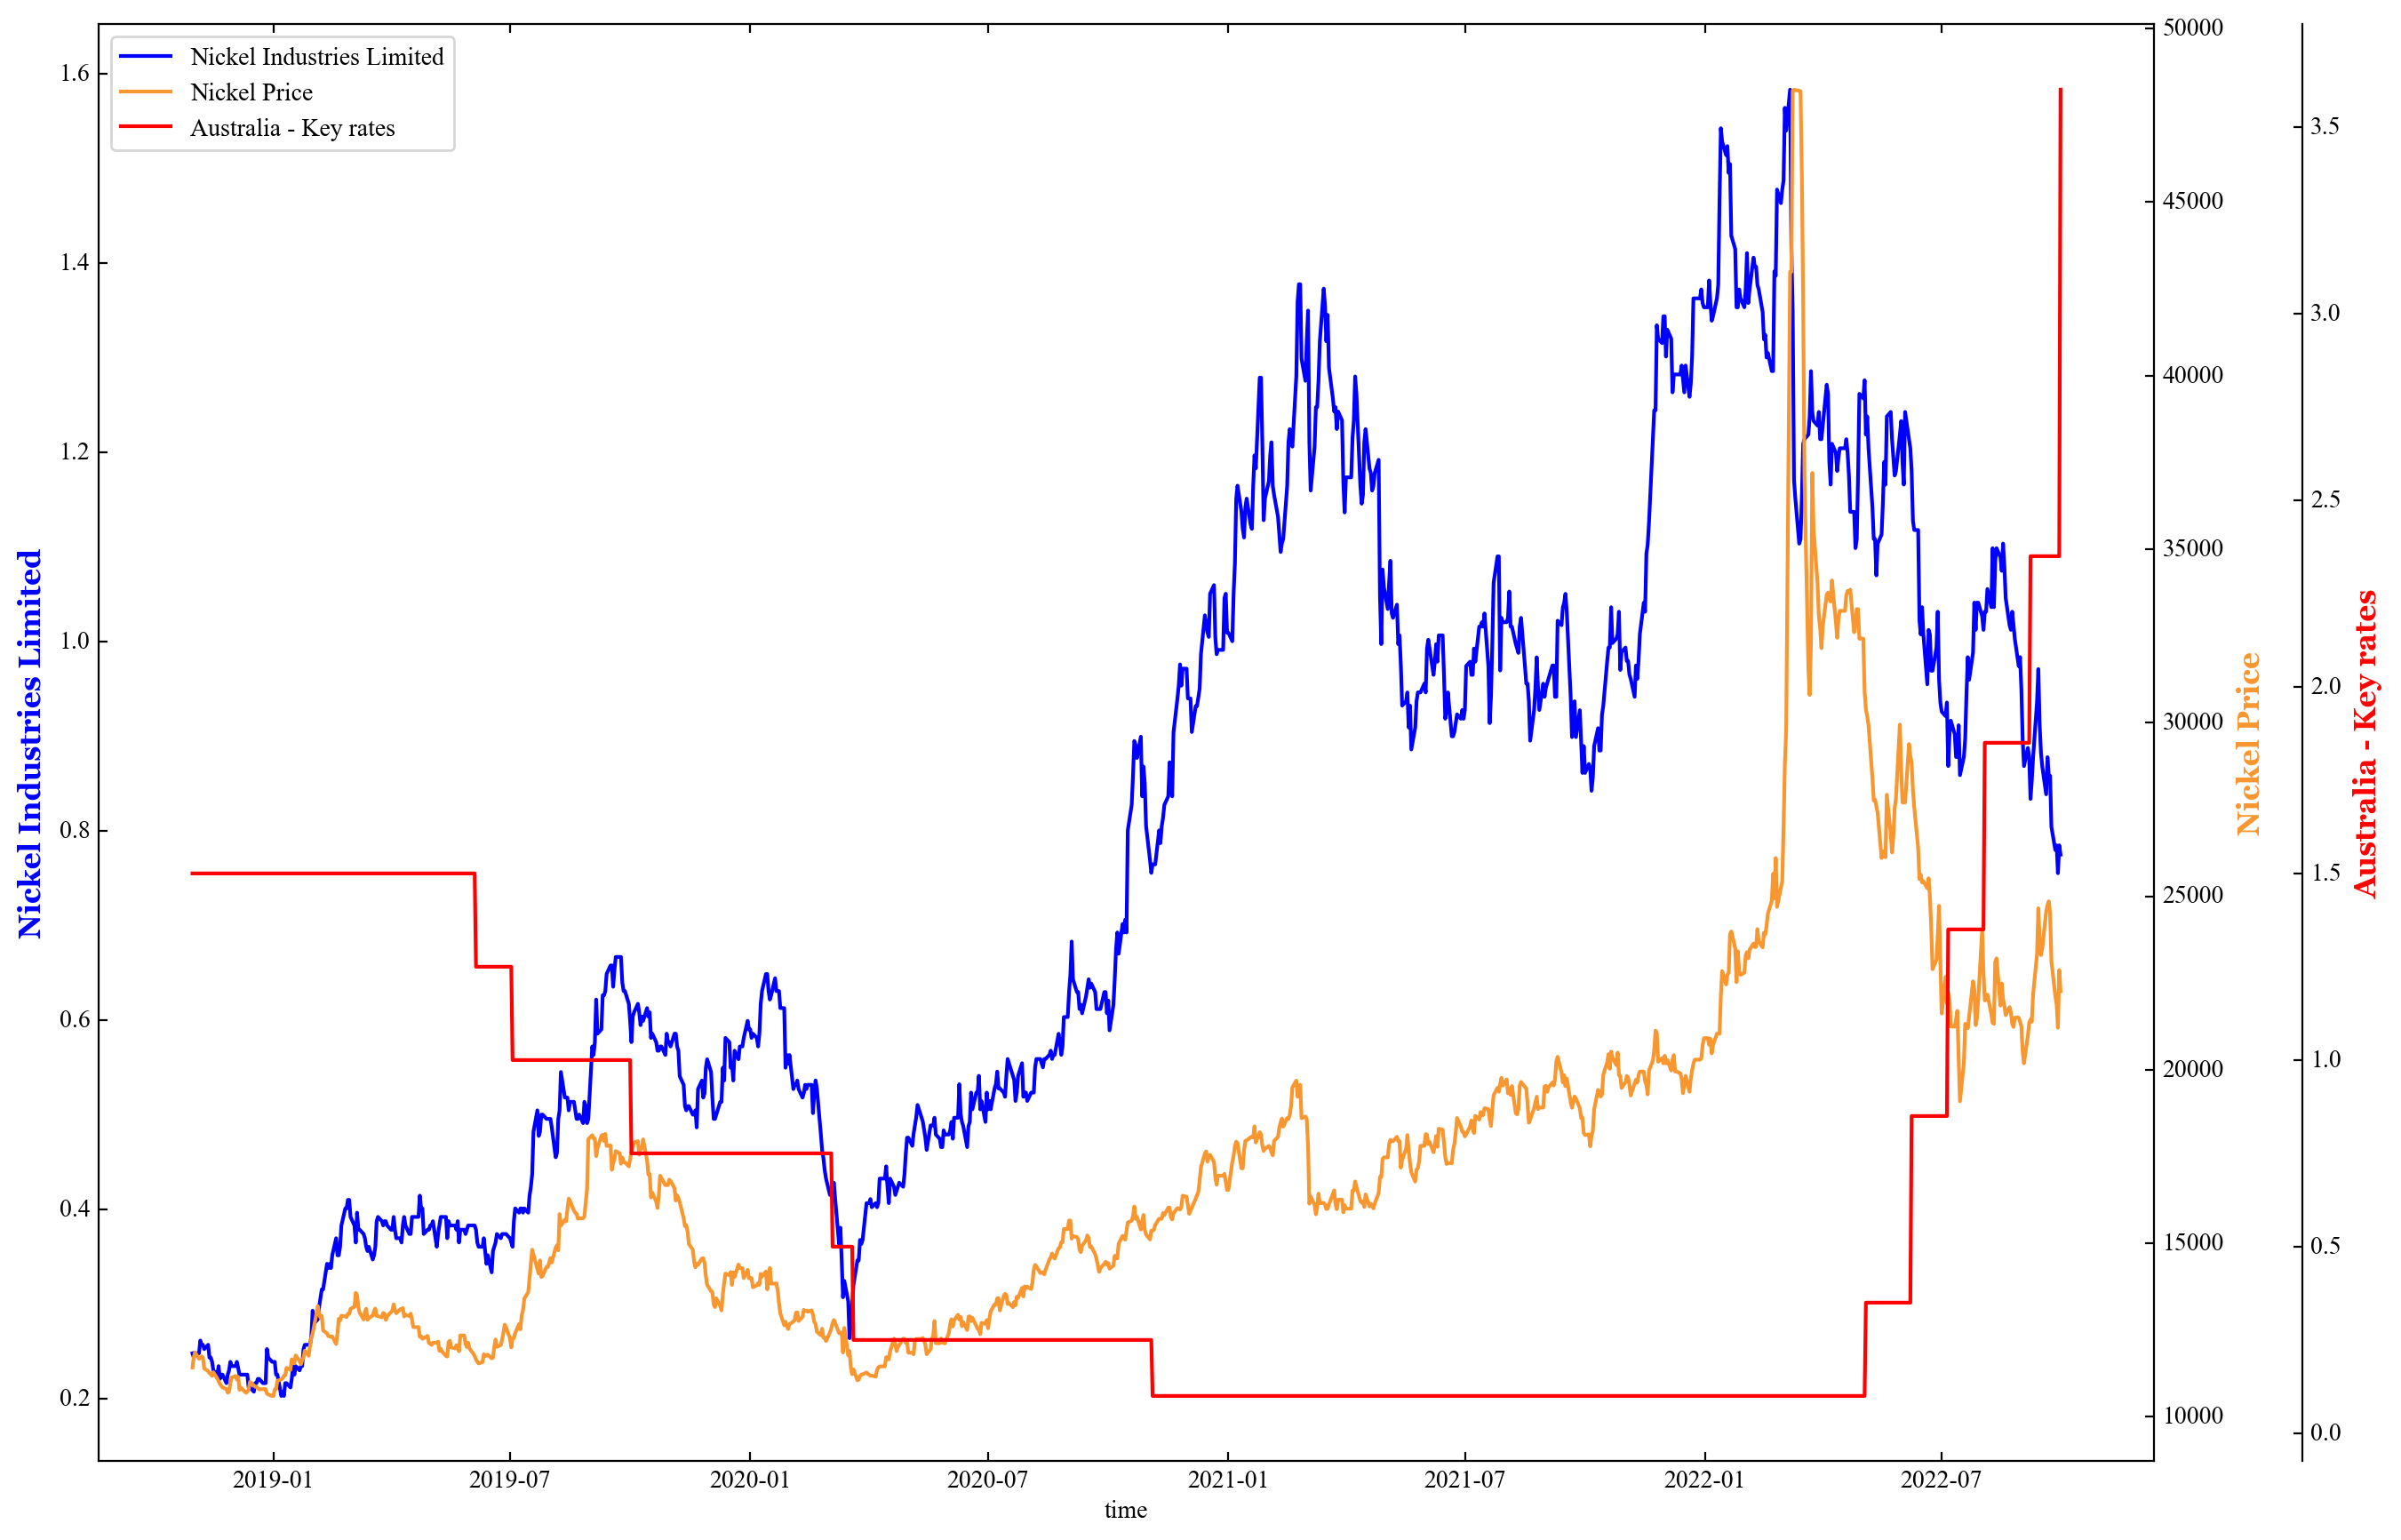

In [36]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

plot_nick_rate_nic(nickel_df, rates, nic_df)

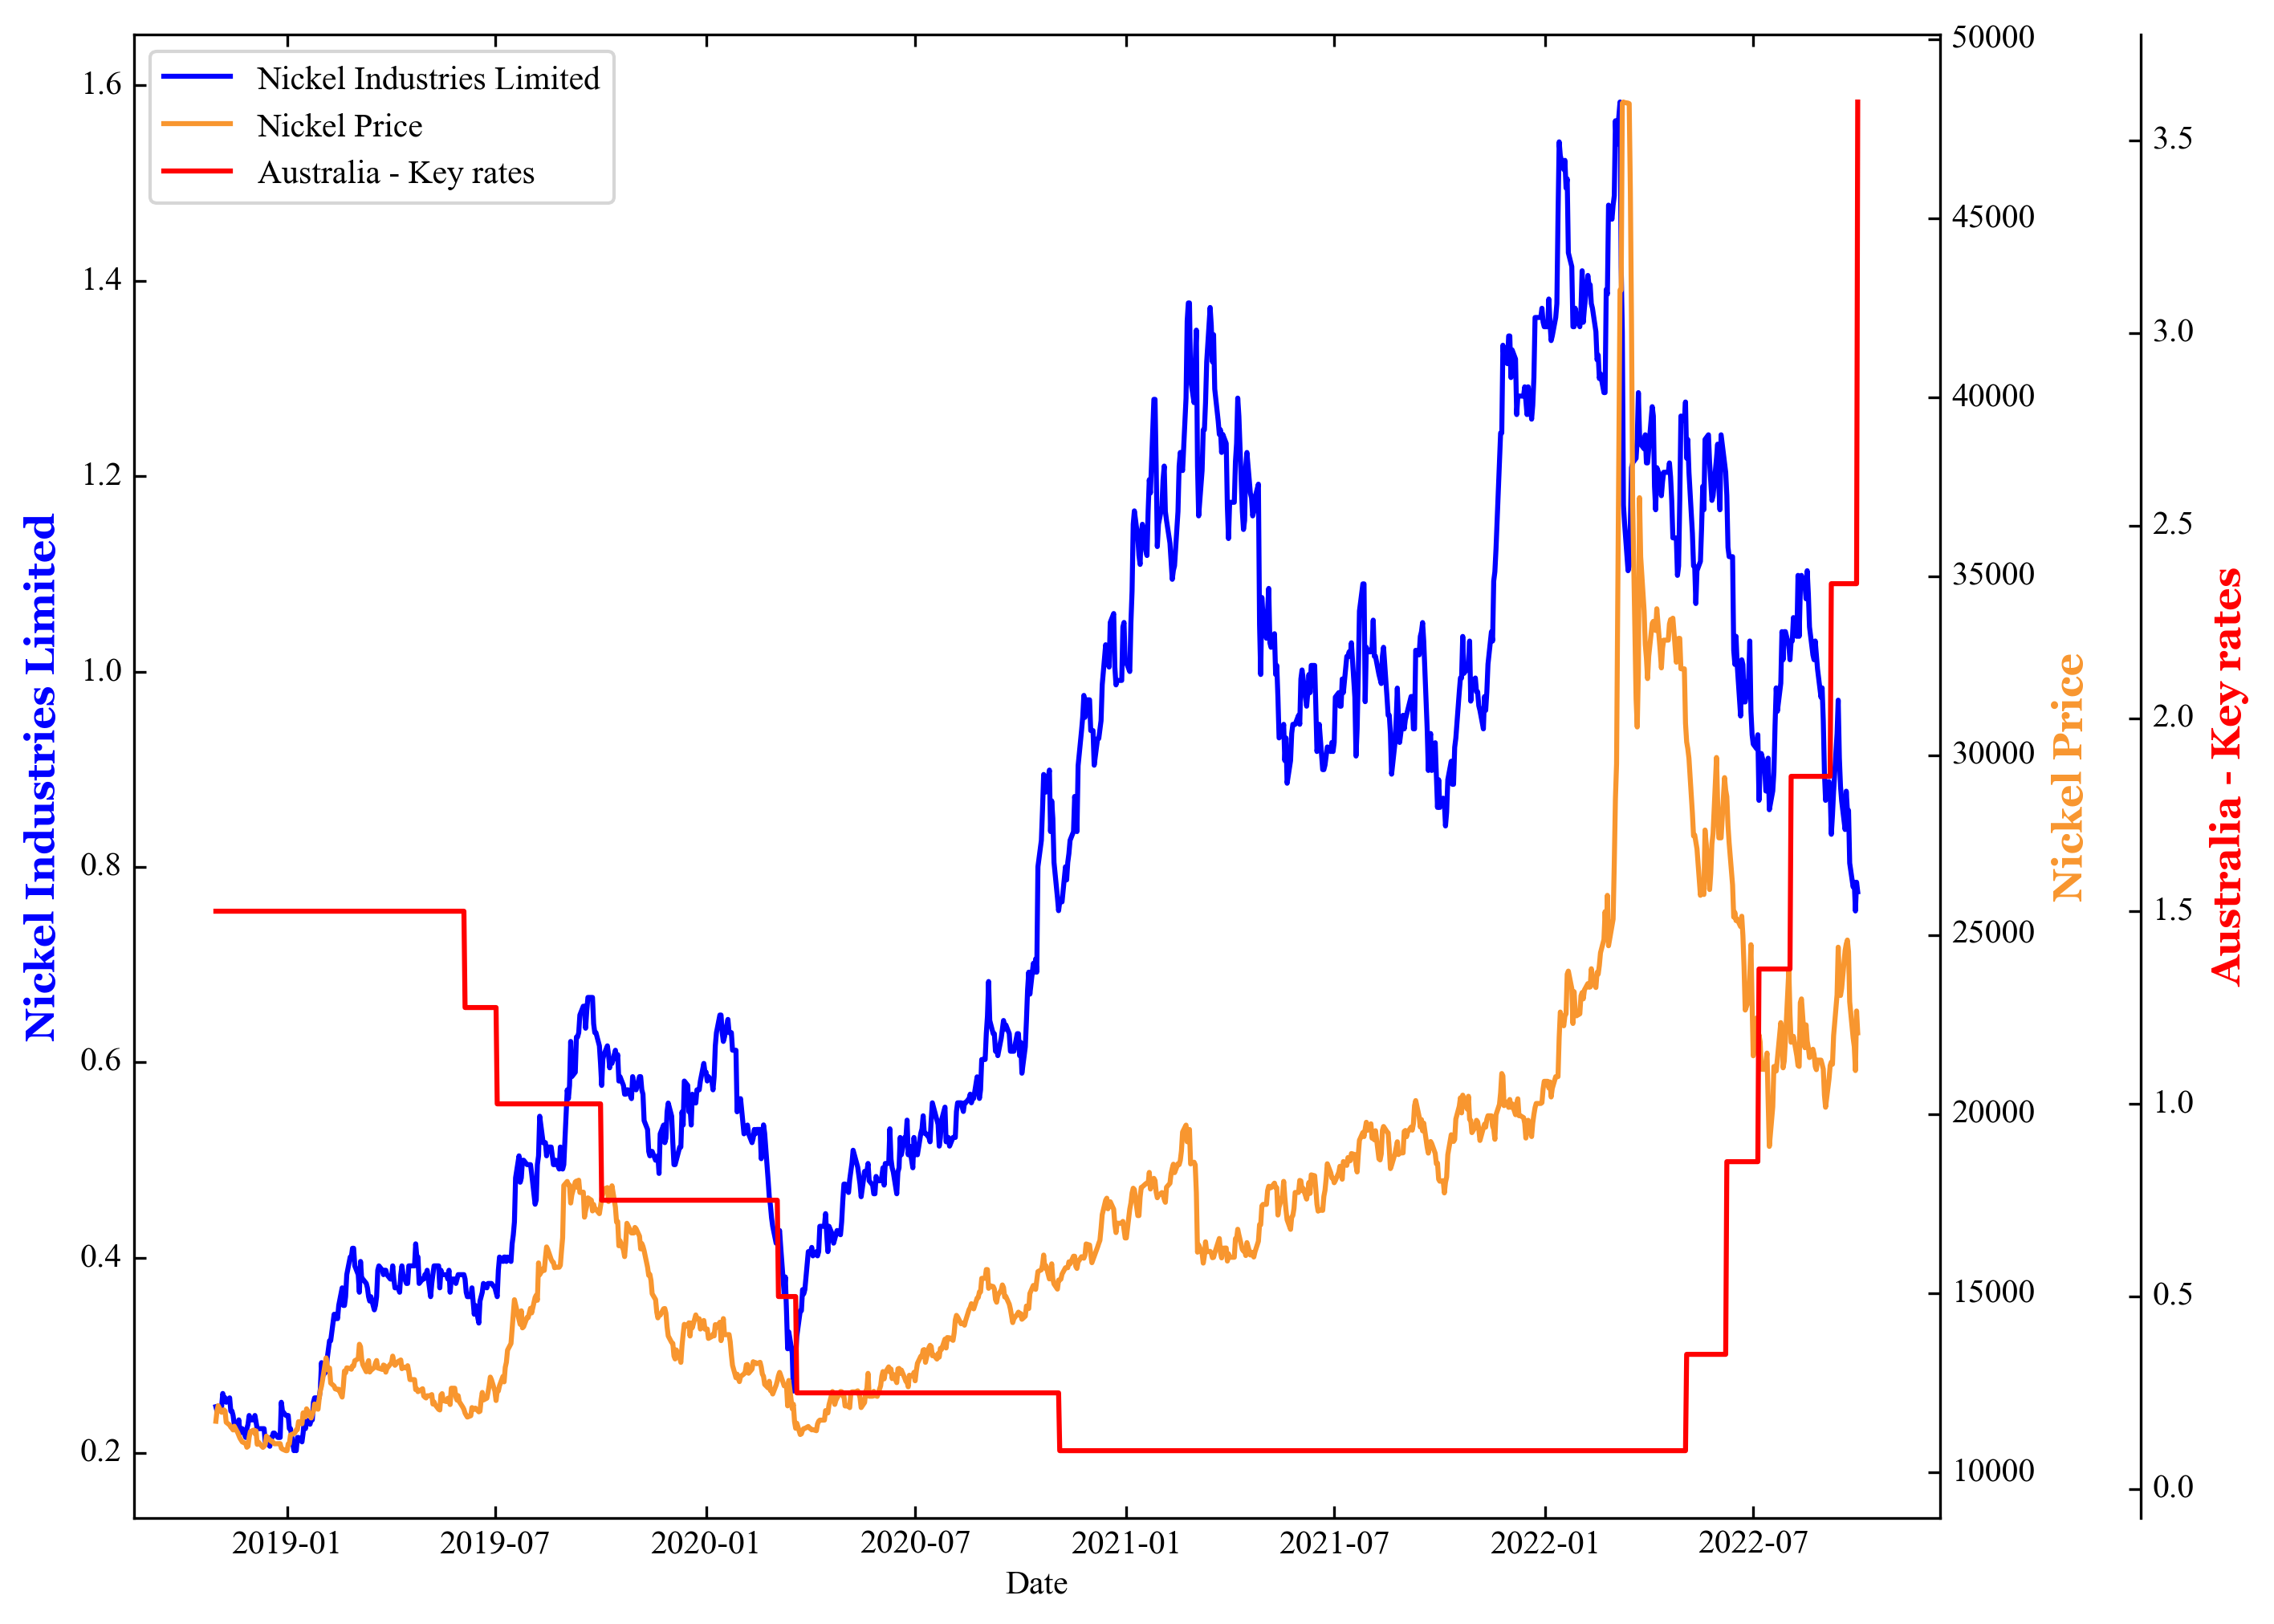

In [37]:
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
    
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)
    
p1, = host.plot(nic_df.index, nic_df['Close'], label="Nickel Industries Limited", color="blue")
p2, = par1.plot(nic_df.index, nickel_df['Close'], label="Nickel Price", color="#f8962f")
p3, = par2.plot(nic_df.index, rates['rate'], label="Australia - Key rates", color="red")
    
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Nickel Industries Limited")
par1.set_ylabel("Nickel Price")
par2.set_ylabel("Australia - Key rates")
    
host.legend()
    
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
    
host.axis["left"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par1.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par2.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
    
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.set_dpi(300)

# plt.savefig('images/Example.png', dpi=300)

plt.show()

In [38]:
data = union_data_in_one_df(nickel_df, rates, nic_df, currency_df, production, mining, ind_exp)

In [39]:
(endog, exog) = get_endog_and_exog(data)

Text(0.5, 0.98, '')

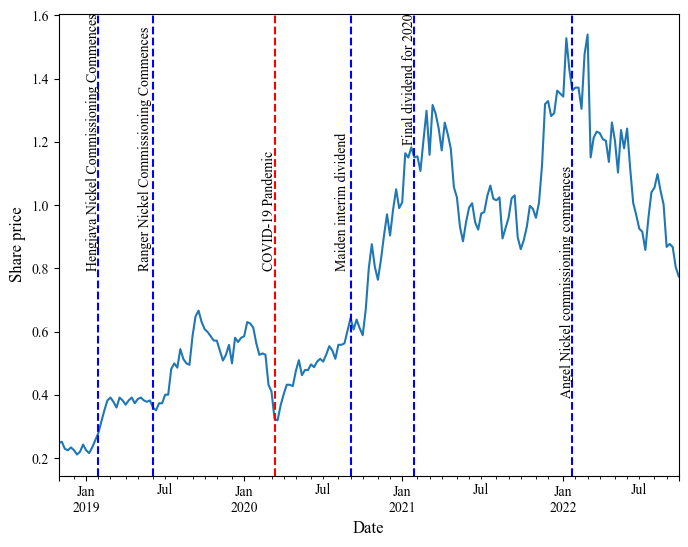

In [40]:
plt.rcParams["font.family"] = "Times New Roman"

ax = data[endog].plot(figsize=(8, 6))

ax.axvline('2020-03-11', color='red', linestyle='--',)
plt.text('2020-02-11', 0.8, s='COVID-19 Pandemic', rotation=90)


ax.axvline('2019-02-01', color='blue', linestyle='--',)
plt.text('2019-01-01', 0.8, s='Hengjaya Nickel Commissioning Commences', rotation=90)

ax.axvline('2019-06-03', color='blue', linestyle='--',)
plt.text('2019-05-03', 0.8, s='Ranger Nickel Commissioning Commences', rotation=90)

ax.axvline('2020-08-31', color='blue', linestyle='--',)
plt.text('2020-07-31', 0.8, s='Maiden interim dividend', rotation=90)

ax.axvline('2021-01-28', color='blue', linestyle='--',)
plt.text('2020-12-28', 1.2, s='Final dividend for 2020', rotation=90)

ax.axvline('2022-01-27', color='blue', linestyle='--',)
plt.text('2021-12-27', 0.4, s='Angel Nickel commissioning commences', rotation=90)

ax.set_xlabel("")

ax.set_ylabel("Share price", fontname="Times New Roman", fontsize=12)

ax.set_label("")


ax.get_figure().gca().set_xlabel("Date", fontname="Times New Roman", fontsize=12)
ax.get_figure().suptitle('')

# ax.set_title("Share price of Nickel Industries Limited", fontname="Times New Roman", fontsize=18)

# plt.savefig('images/Share price of Nickel Industries Limited.png', dpi=300)

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>,
       <AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

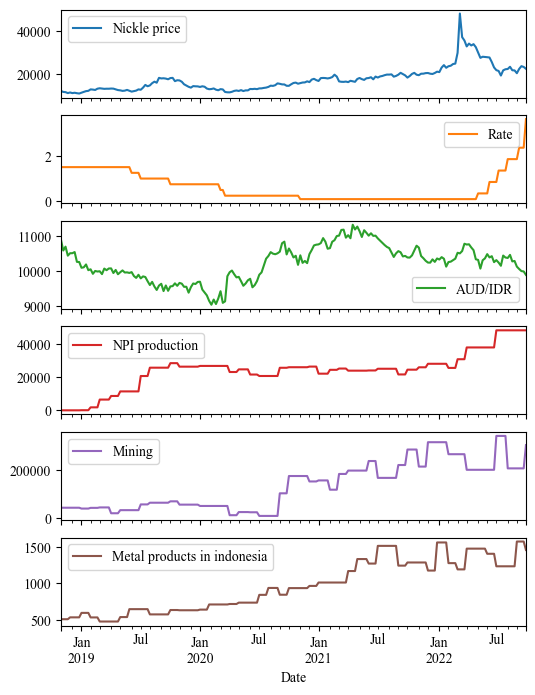

In [41]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

data[exog].plot(subplots=True, figsize=(6, 8), linewidth=1.5, sharey=False)

# plt.savefig('images/Data.png', dpi=300)

<AxesSubplot: >

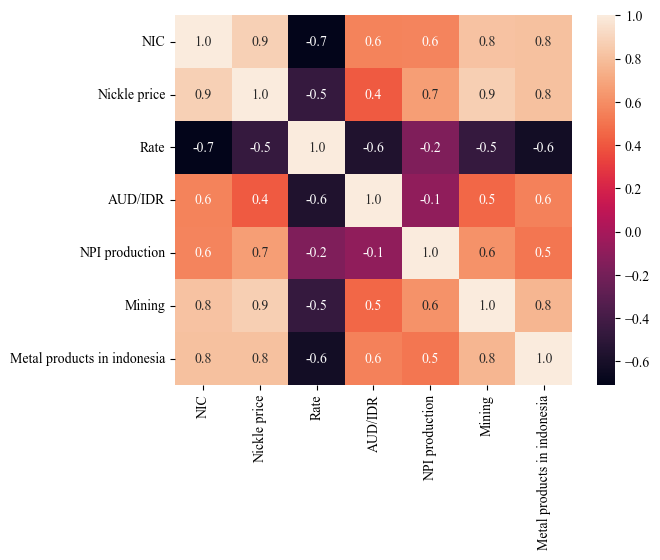

In [42]:
import seaborn as sns

sns.heatmap(data.corr(method="spearman"), annot=True, fmt=".1f")

# plt.savefig('images/Heatmap.png', dpi=300)

In [43]:
data = data.asfreq(freq='W-FRI').fillna(method='ffill')

In [44]:
from statsmodels.tsa.stattools import adfuller, kpss

adf_price = adfuller(data['NIC'])
print("p-value of ADF: {}".format(float(adf_price[1].round(4))))

kpss_test = kpss(data['NIC'])
print("p-value of KPSS: {}".format(float(kpss_test[1].round(4))))

p-value of ADF: 0.4667
p-value of KPSS: 0.01


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [45]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

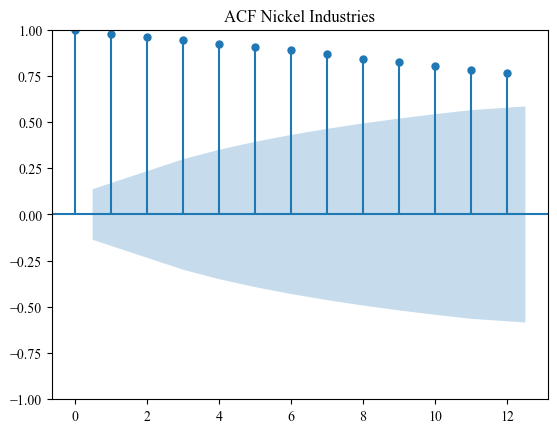

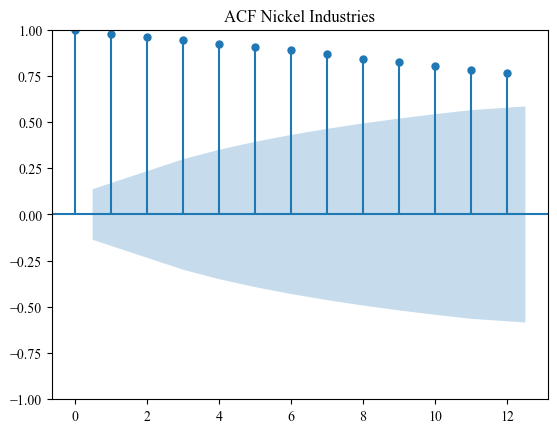

In [46]:
plot_acf(data['NIC'], lags=12,  title="ACF Nickel Industries")

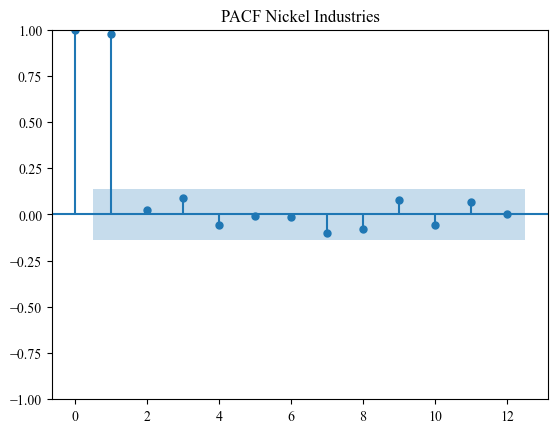

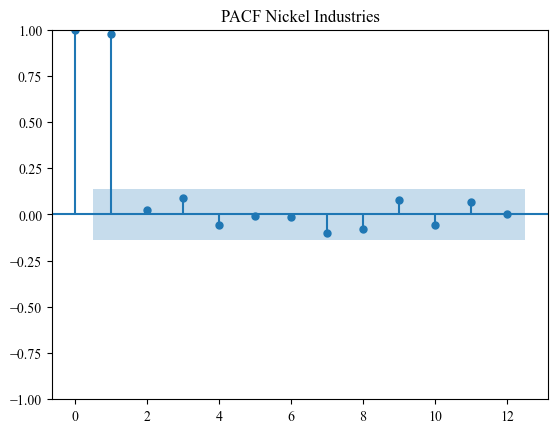

In [47]:
plot_pacf(data['NIC'], lags=12, method='ywm', title="PACF Nickel Industries")

# plt.savefig('images/PACF Nickel Industries.png', dpi=300)

In [48]:
data_diff = data.copy()
data_diff['NIC'] = data['NIC'].diff()
data_diff = data_diff.fillna(0)

In [49]:
data['NIC'].iloc[0]

0.2477053701877594

In [50]:
data_diff.head()

,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
Date,,,,,,,
2018-11-02 00:00:00+11:00,0.000000,11860.5,1.5,10885.799805,0.0,43322.0,506.75
2018-11-09 00:00:00+11:00,0.004504,11397.0,1.5,10583.400391,0.0,43322.0,506.75
2018-11-16 00:00:00+11:00,-0.022519,11287.0,1.5,10692.700195,0.0,43322.0,506.75
2018-11-23 00:00:00+11:00,-0.004504,10849.0,1.5,10437.400391,0.0,43322.0,506.75
2018-11-30 00:00:00+11:00,0.009007,11135.5,1.5,10506.400391,0.0,43322.0,532.13


In [51]:
data_diff['NIC'].cumsum().head()

Date
2018-11-02 00:00:00+11:00    0.000000
2018-11-09 00:00:00+11:00    0.004504
2018-11-16 00:00:00+11:00   -0.018015
2018-11-23 00:00:00+11:00   -0.022519
2018-11-30 00:00:00+11:00   -0.013511
Freq: W-FRI, Name: NIC, dtype: float64

In [52]:
data.head()

,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
Date,,,,,,,
2018-11-02 00:00:00+11:00,0.247705,11860.5,1.5,10885.799805,0.0,43322.0,506.75
2018-11-09 00:00:00+11:00,0.252209,11397.0,1.5,10583.400391,0.0,43322.0,506.75
2018-11-16 00:00:00+11:00,0.229690,11287.0,1.5,10692.700195,0.0,43322.0,506.75
2018-11-23 00:00:00+11:00,0.225187,10849.0,1.5,10437.400391,0.0,43322.0,506.75
2018-11-30 00:00:00+11:00,0.234194,11135.5,1.5,10506.400391,0.0,43322.0,532.13


In [53]:
data.describe()

,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.773109,17300.215854,0.626829,10226.793631,24104.616585,131909.830894,957.315024
std,0.351511,5701.492999,0.632465,501.638606,11106.524631,96718.721005,347.196964
min,0.211676,10647.000000,0.100000,9043.581055,0.000000,9500.000000,475.150000
25%,0.486403,12903.000000,0.100000,9890.727539,21645.000000,43322.000000,632.360000
50%,0.764341,16222.000000,0.250000,10286.171875,25271.100000,117728.000000,931.730000
75%,1.045725,19546.000000,1.000000,10550.154297,26858.000000,199863.333333,1267.050000
max,1.539806,48226.000000,3.600000,11315.769531,48393.333333,339672.000000,1568.340000


<AxesSubplot: xlabel='Date'>

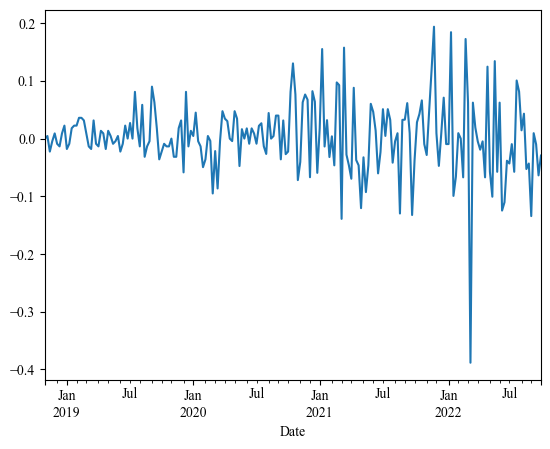

In [54]:
data_diff['NIC'].plot()

In [55]:
adf_price = adfuller(data_diff['NIC'])
print("p-value of ADF: {}".format(float(adf_price[1].round(4))))

kpss_test = kpss(data_diff['NIC'])
print("p-value of KPSS: {}".format(float(kpss_test[1].round(4))))

p-value of ADF: 0.0
p-value of KPSS: 0.1


/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


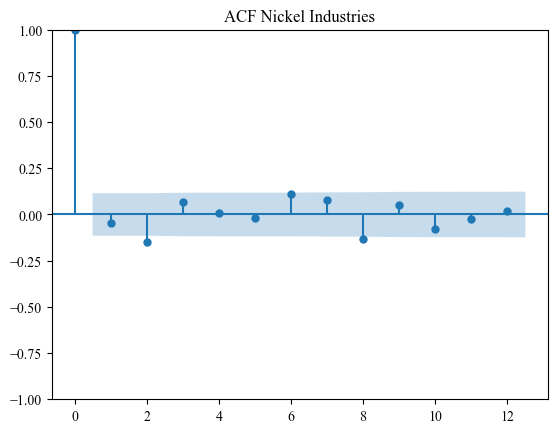

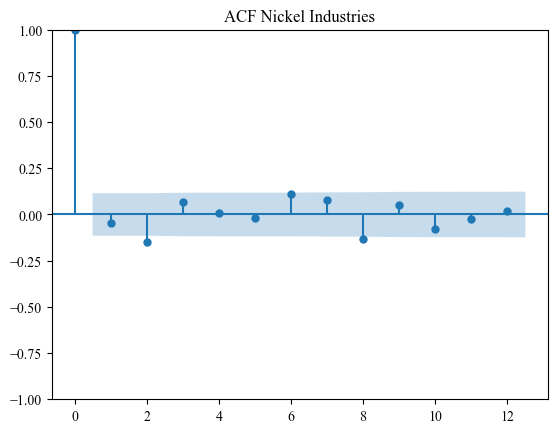

In [56]:
plot_acf(data_diff['NIC'], lags=12,  title="ACF Nickel Industries", alpha=0.1)

# plt.savefig('images/ACF Nickel Industries.png', dpi=300)

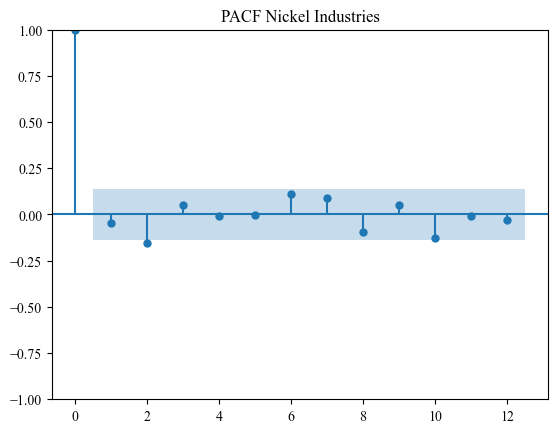

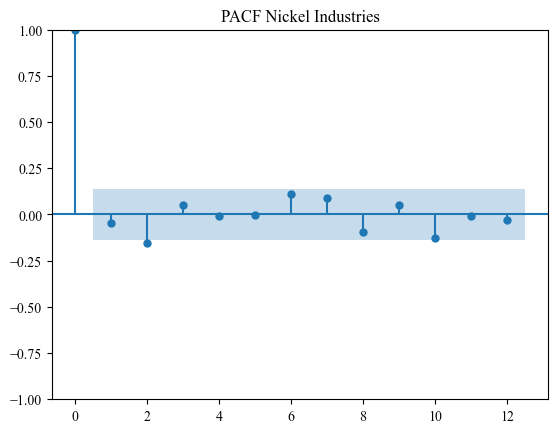

In [57]:
plot_pacf(data_diff['NIC'], lags=12, method='ywm', title="PACF Nickel Industries")

# plt.savefig('images/PACF Nickel Industries.png', dpi=300)

In [482]:
train_data = data[data.index < '2022-04-21']
test_data = data[data.index >= '2022-04-21'] 

(endog, exog) = get_endog_and_exog(data)
# 6,0,0 0.07   

mod = sm.tsa.arima.ARIMA(order=(5, 1, 9), endog=train_data[endog], exog=train_data[exog])
res = mod.fit()

/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [483]:
train_data['NIC'].iloc[0] = data['NIC'].iloc[0]
train_data.head()

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_95327/3022902496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['NIC'].iloc[0] = data['NIC'].iloc[0]


,NIC,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
Date,,,,,,,
2018-11-02 00:00:00+11:00,0.247705,11860.5,1.5,10885.799805,0.0,43322.0,506.75
2018-11-09 00:00:00+11:00,0.252209,11397.0,1.5,10583.400391,0.0,43322.0,506.75
2018-11-16 00:00:00+11:00,0.229690,11287.0,1.5,10692.700195,0.0,43322.0,506.75
2018-11-23 00:00:00+11:00,0.225187,10849.0,1.5,10437.400391,0.0,43322.0,506.75
2018-11-30 00:00:00+11:00,0.234194,11135.5,1.5,10506.400391,0.0,43322.0,532.13


In [484]:
res.fittedvalues.iloc[0] = data['NIC'].iloc[0]
res.fittedvalues.head()

Date
2018-11-02 00:00:00+11:00    0.247705
2018-11-09 00:00:00+11:00    0.239633
2018-11-16 00:00:00+11:00    0.258437
2018-11-23 00:00:00+11:00    0.220240
2018-11-30 00:00:00+11:00    0.225122
Freq: W-FRI, dtype: float64

In [485]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NIC   No. Observations:                  181
Model:                 ARIMA(5, 1, 9)   Log Likelihood                 268.887
Date:                Tue, 28 Mar 2023   AIC                           -495.773
Time:                        21:59:53   BIC                           -428.721
Sample:                    11-02-2018   HQIC                          -468.587
                         - 04-15-2022                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Nickle price                -9.805e-06   2.03e-06     -4.833      0.000   -1.38e-05   -5.83e-06
Rate                            0.0841      0.223      0.378      0.706      -0.352       0.521
AUD/IDR                      4.172e-05      4e-05      1.042      0.297   -3.67e-05       0.000
NPI production               3.011e-06   4.63e-06      0.651      0.515   -6.06e-06    1.21e-05
Mining                      -4.552e-07   3.19e-07     -1.426      0.154   -1.08e-06     1.7e-07
Metal products in indonesia    -0.0002      0.000     -1.316      0.188      -0.000    7.48e-05
ar.L1                          -0.3713      0.532     -0.698      0.485      -1.414       0.671
ar.L2                          -0.8674      0.362     -2.398      0.016      -1.576      -0.159
ar.L3                          -0.5426      0.513     -1.059      0.290      -1.547       0.462
ar.L4                          -0.5070      0.272     -1.866      0.062      -1.040       0.026
ar.L5                          -0.5331      0.416     -1.281      0.200      -1.348       0.282
ma.L1                           0.3550      0.526      0.675      0.500      -0.676       1.386
ma.L2                           0.7486      0.363      2.062      0.039       0.037       1.460
ma.L3                           0.5352      0.467      1.146      0.252      -0.380       1.451
ma.L4                           0.5707      0.268      2.126      0.033       0.045       1.097
ma.L5                           0.6077      0.430      1.412      0.158      -0.236       1.451
ma.L6                           0.2778      0.155      1.792      0.073      -0.026       0.582
ma.L7                           0.3309      0.168      1.969      0.049       0.001       0.660
ma.L8                           0.2513      0.163      1.545      0.122      -0.067       0.570
ma.L9                           0.2527      0.162      1.561      0.118      -0.065       0.570
sigma2                          0.0034      0.000      9.117      0.000       0.003       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                12.62
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.70   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

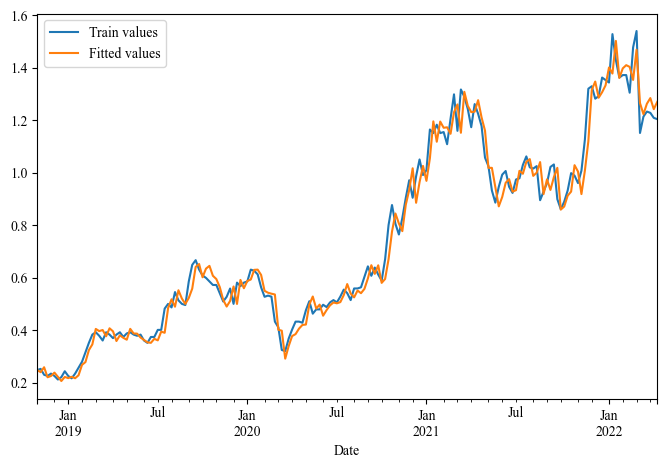

In [486]:
fig, ax = plt.subplots(figsize=(8, 5))
    
train_data[endog].plot(ax=ax)
    
res.fittedvalues.plot(ax=ax)

ax.legend(['Train values', 'Fitted values'])

# plt.savefig('images/FittedValue.png', dpi=300)

In [487]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

mean_absolute_percentage_error(train_data[endog], res.fittedvalues)

0.0562881738618195

In [488]:
from sklearn.metrics import mean_squared_error

mean_squared_error(train_data[endog], res.fittedvalues)

0.0028764642572764103

In [66]:
first_value = pd.DataFrame(data=[{
    'mean': train_data.cumsum().iloc[-1]['NIC'], 
    'mean_se': train_data.cumsum().iloc[-1]['NIC'], 
    'mean_ci_lower': train_data.cumsum().iloc[-1]['NIC'], 
    'mean_ci_upper': train_data.cumsum().iloc[-1]['NIC'],}], index=[train_data.index[-1]])

In [67]:
train_data.iloc[-1]

NIC                            1.204023e+00
Nickle price                   2.958321e+06
Rate                           9.785000e+01
AUD/IDR                        1.849994e+06
NPI production                 3.883586e+06
Mining                         2.139688e+07
Metal products in indonesia    1.630253e+05
Name: 2022-04-15 00:00:00+10:00, dtype: float64

meanabs 0.27399275888561764
mse 0.10699430689199031
rmse 0.32709984239065343


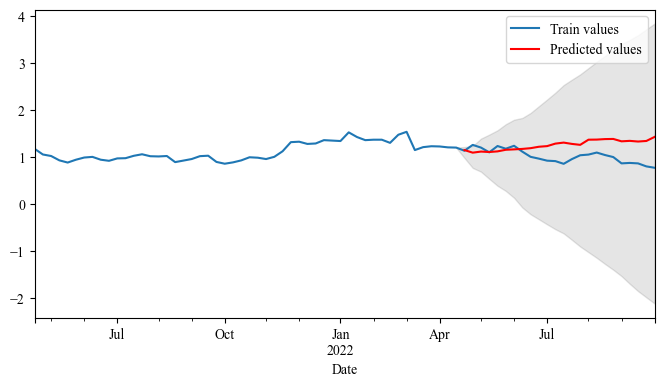

In [489]:
predicted_value = res.get_prediction(test_data.index[0], test_data.index[-1], exog=test_data[exog]).summary_frame()

# predicted_value_for_figure = predicted_value.append(first_value).sort_index()

fig, ax = plt.subplots(figsize=(8, 4))
# test_data.append(train_data.cumsum().iloc[-1]).cumsum().sort_index()[endog].plot(ax=ax)
data[endog]["2021-04-20":].plot(ax=ax)

predicted_value['mean'].plot(ax=ax, color='red')
ax.fill_between(
        predicted_value_for_figure.index, 
        predicted_value_for_figure['mean_ci_lower'].cumsum(), 
        predicted_value_for_figure['mean_ci_upper'].cumsum(), 
        color='k',
        alpha=0.1);

ax.legend(['Train values', 'Predicted values'])

# plt.savefig('images/PredictedValue.png', dpi=300)

from statsmodels.tools.eval_measures import meanabs, mse, rmse

    
print('meanabs', meanabs(test_data[endog], predicted_value['mean']))
print('mse', mse(test_data[endog], predicted_value['mean']))
print('rmse', rmse(test_data[endog], predicted_value['mean']))

In [69]:
import time
from datetime import datetime
import numpy as np

def ARIMAGridSearch(y_train, x_train, p_params, q_params, d_params):
    # Create dictionary to store MAPEs
    mape_grid = dict()
    rmse_grid = dict()
    grid = dict()
    # Outer loop: Iterate through possible values for `p`
    for p in p_params:
        # Create key-value pair in dict. Key is `p`, value is empty list.
        mape_grid[p] = list()
        rmse_grid[p] = list()
        # Inner loop: Iterate through possible values for `q`
        for q in q_params:
            # Combination of hyperparameters for model
            order = (p, d_params, q)
            # Note start time
            start_time = time.time()
            # Train model
            model = sm.tsa.arima.ARIMA(y_train, exog=x_train, order=order).fit()
            # Generate in-sample (training) predictions
            y_pred = model.predict()
            # Calculate training MAE
            mape = mean_absolute_percentage_error(y_train, y_pred)
            mse = mean_squared_error(y_train, y_pred, squared=False)
            # Calculate model training time
            elapsed_time = round(time.time() - start_time, 2)
            print(f"Trained ARIMA {order} in {elapsed_time} seconds. MAPE is {mape.round(6)}. RMSE is {mse.round(6)}")
            grid[order] = [order, mape.round(6), mse.round(6)]
            # Append MAE to list in dictionary
            mape_grid[p].append(mape)
            rmse_grid[p].append(mse)
            
    
    cols = ['AR' + str(x) for x in p_params]
    index = ['MA' + str(x) for x in q_params]
    grid_arima_mape = pd.DataFrame.from_dict(mape_grid)
    grid_arima_mape.columns = cols
    grid_arima_mape.index = index
    grid_arima_rmse = pd.DataFrame.from_dict(rmse_grid)
    grid_arima_rmse.columns = cols
    grid_arima_rmse.index = index
    
    return grid_arima_mape, grid_arima_rmse, grid

In [70]:
p_params = range(0, 10, 1)
q_params = range(0, 10, 1)
d_params = 0

# ARIMAGridSearch(train_data[endog], train_data[exog], p_params = p_params, q_params = q_params, d_params = 0)


In [497]:
last_mod = sm.tsa.arima.ARIMA(order=(5, 1, 9), endog=data[endog], exog=data[exog])
last_res = last_mod.fit()

/Users/germanignatovich/Desktop/projects/hse/TS/ts-project-assignment-hse-2023/venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [498]:
last_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    NIC   No. Observations:                  205
Model:                 ARIMA(5, 1, 9)   Log Likelihood                 288.925
Date:                Tue, 28 Mar 2023   AIC                           -535.850
Time:                        22:02:41   BIC                           -466.169
Sample:                    11-02-2018   HQIC                          -507.663
                         - 09-30-2022                                         
Covariance Type:                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Nickle price                -7.247e-06   1.75e-06     -4.148      0.000   -1.07e-05   -3.82e-06
Rate                           -0.0282      0.071     -0.398      0.691      -0.167       0.111
AUD/IDR                      6.286e-05   4.35e-05      1.444      0.149   -2.24e-05       0.000
NPI production               9.497e-07   5.73e-06      0.166      0.868   -1.03e-05    1.22e-05
Mining                        -5.1e-07   3.25e-07     -1.571      0.116   -1.15e-06    1.26e-07
Metal products in indonesia    -0.0002   9.12e-05     -2.016      0.044      -0.000   -5.08e-06
ar.L1                          -0.3170      0.375     -0.845      0.398      -1.053       0.419
ar.L2                          -0.7882      0.291     -2.706      0.007      -1.359      -0.217
ar.L3                          -0.5474      0.365     -1.501      0.133      -1.262       0.167
ar.L4                          -0.5419      0.264     -2.054      0.040      -1.059      -0.025
ar.L5                          -0.5311      0.352     -1.508      0.131      -1.221       0.159
ma.L1                           0.2999      0.379      0.791      0.429      -0.443       1.043
ma.L2                           0.7012      0.285      2.457      0.014       0.142       1.261
ma.L3                           0.5625      0.354      1.590      0.112      -0.131       1.256
ma.L4                           0.5256      0.264      1.994      0.046       0.009       1.042
ma.L5                           0.5856      0.328      1.788      0.074      -0.056       1.228
ma.L6                           0.0951      0.153      0.622      0.534      -0.204       0.395
ma.L7                           0.1721      0.131      1.315      0.189      -0.085       0.429
ma.L8                           0.0757      0.111      0.684      0.494      -0.141       0.293
ma.L9                           0.1640      0.109      1.508      0.132      -0.049       0.377
sigma2                          0.0039      0.000      8.921      0.000       0.003       0.005
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                11.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               5.62   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [499]:
len(pd.date_range(start='2022-10-01', end='2023-03-24', tz='Australia/Sydney', freq="W-FRI"))

25

In [500]:
len(data['Nickle price']['2022-04-12':].values[::-1])

25

In [501]:
positive_future_data = pd.DataFrame(data={
    'Nickle price': data['Nickle price']['2022-04-12':].values[::-1],
    'Rate': data['Rate']['2022-04-12':].values[::-1], 
    'AUD/IDR': data['AUD/IDR']['2022-04-12':].values[::-1], 
    'NPI production': data['NPI production']['2022-04-12':].values[::-1], 
    'Mining': data['Mining']['2022-04-12':].values[::-1],
    'Metal products in indonesia': data['Metal products in indonesia']['2022-04-12':].values[::-1]
} , index=pd.date_range(start='2022-10-01', end='2023-03-24', tz='Australia/Sydney', freq="W-FRI"))

In [410]:
positive_future_data.index[0]

Timestamp('2022-10-07 00:00:00+1100', tz='Australia/Sydney', freq='W-FRI')

In [411]:
positive_future_data.index[-1]

Timestamp('2023-03-24 00:00:00+1100', tz='Australia/Sydney', freq='W-FRI')

In [502]:
positive_predicted_value = last_res.get_prediction(
    positive_future_data.index[0], 
    positive_future_data.index[-1], 
    exog=positive_future_data[exog]
).summary_frame()


In [493]:
positive_predicted_value_for_figure = positive_predicted_value

In [415]:
positive_predicted_value_for_figure.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
2022-09-30 00:00:00+10:00,0.774660,0.774660,0.774660,0.774660
2022-10-07 00:00:00+11:00,-0.043304,0.063982,-0.168705,0.082098
2022-10-14 00:00:00+11:00,-0.043815,0.064202,-0.169649,0.082020
2022-10-21 00:00:00+11:00,-0.039966,0.065000,-0.167364,0.087433
2022-10-28 00:00:00+11:00,-0.015755,0.065165,-0.143476,0.111967


In [416]:
positive_predicted_value_for_figure['mean'].cumsum().head()

2022-09-30 00:00:00+10:00    0.774660
2022-10-07 00:00:00+11:00    0.731356
2022-10-14 00:00:00+11:00    0.687542
2022-10-21 00:00:00+11:00    0.647576
2022-10-28 00:00:00+11:00    0.631822
Name: mean, dtype: float64

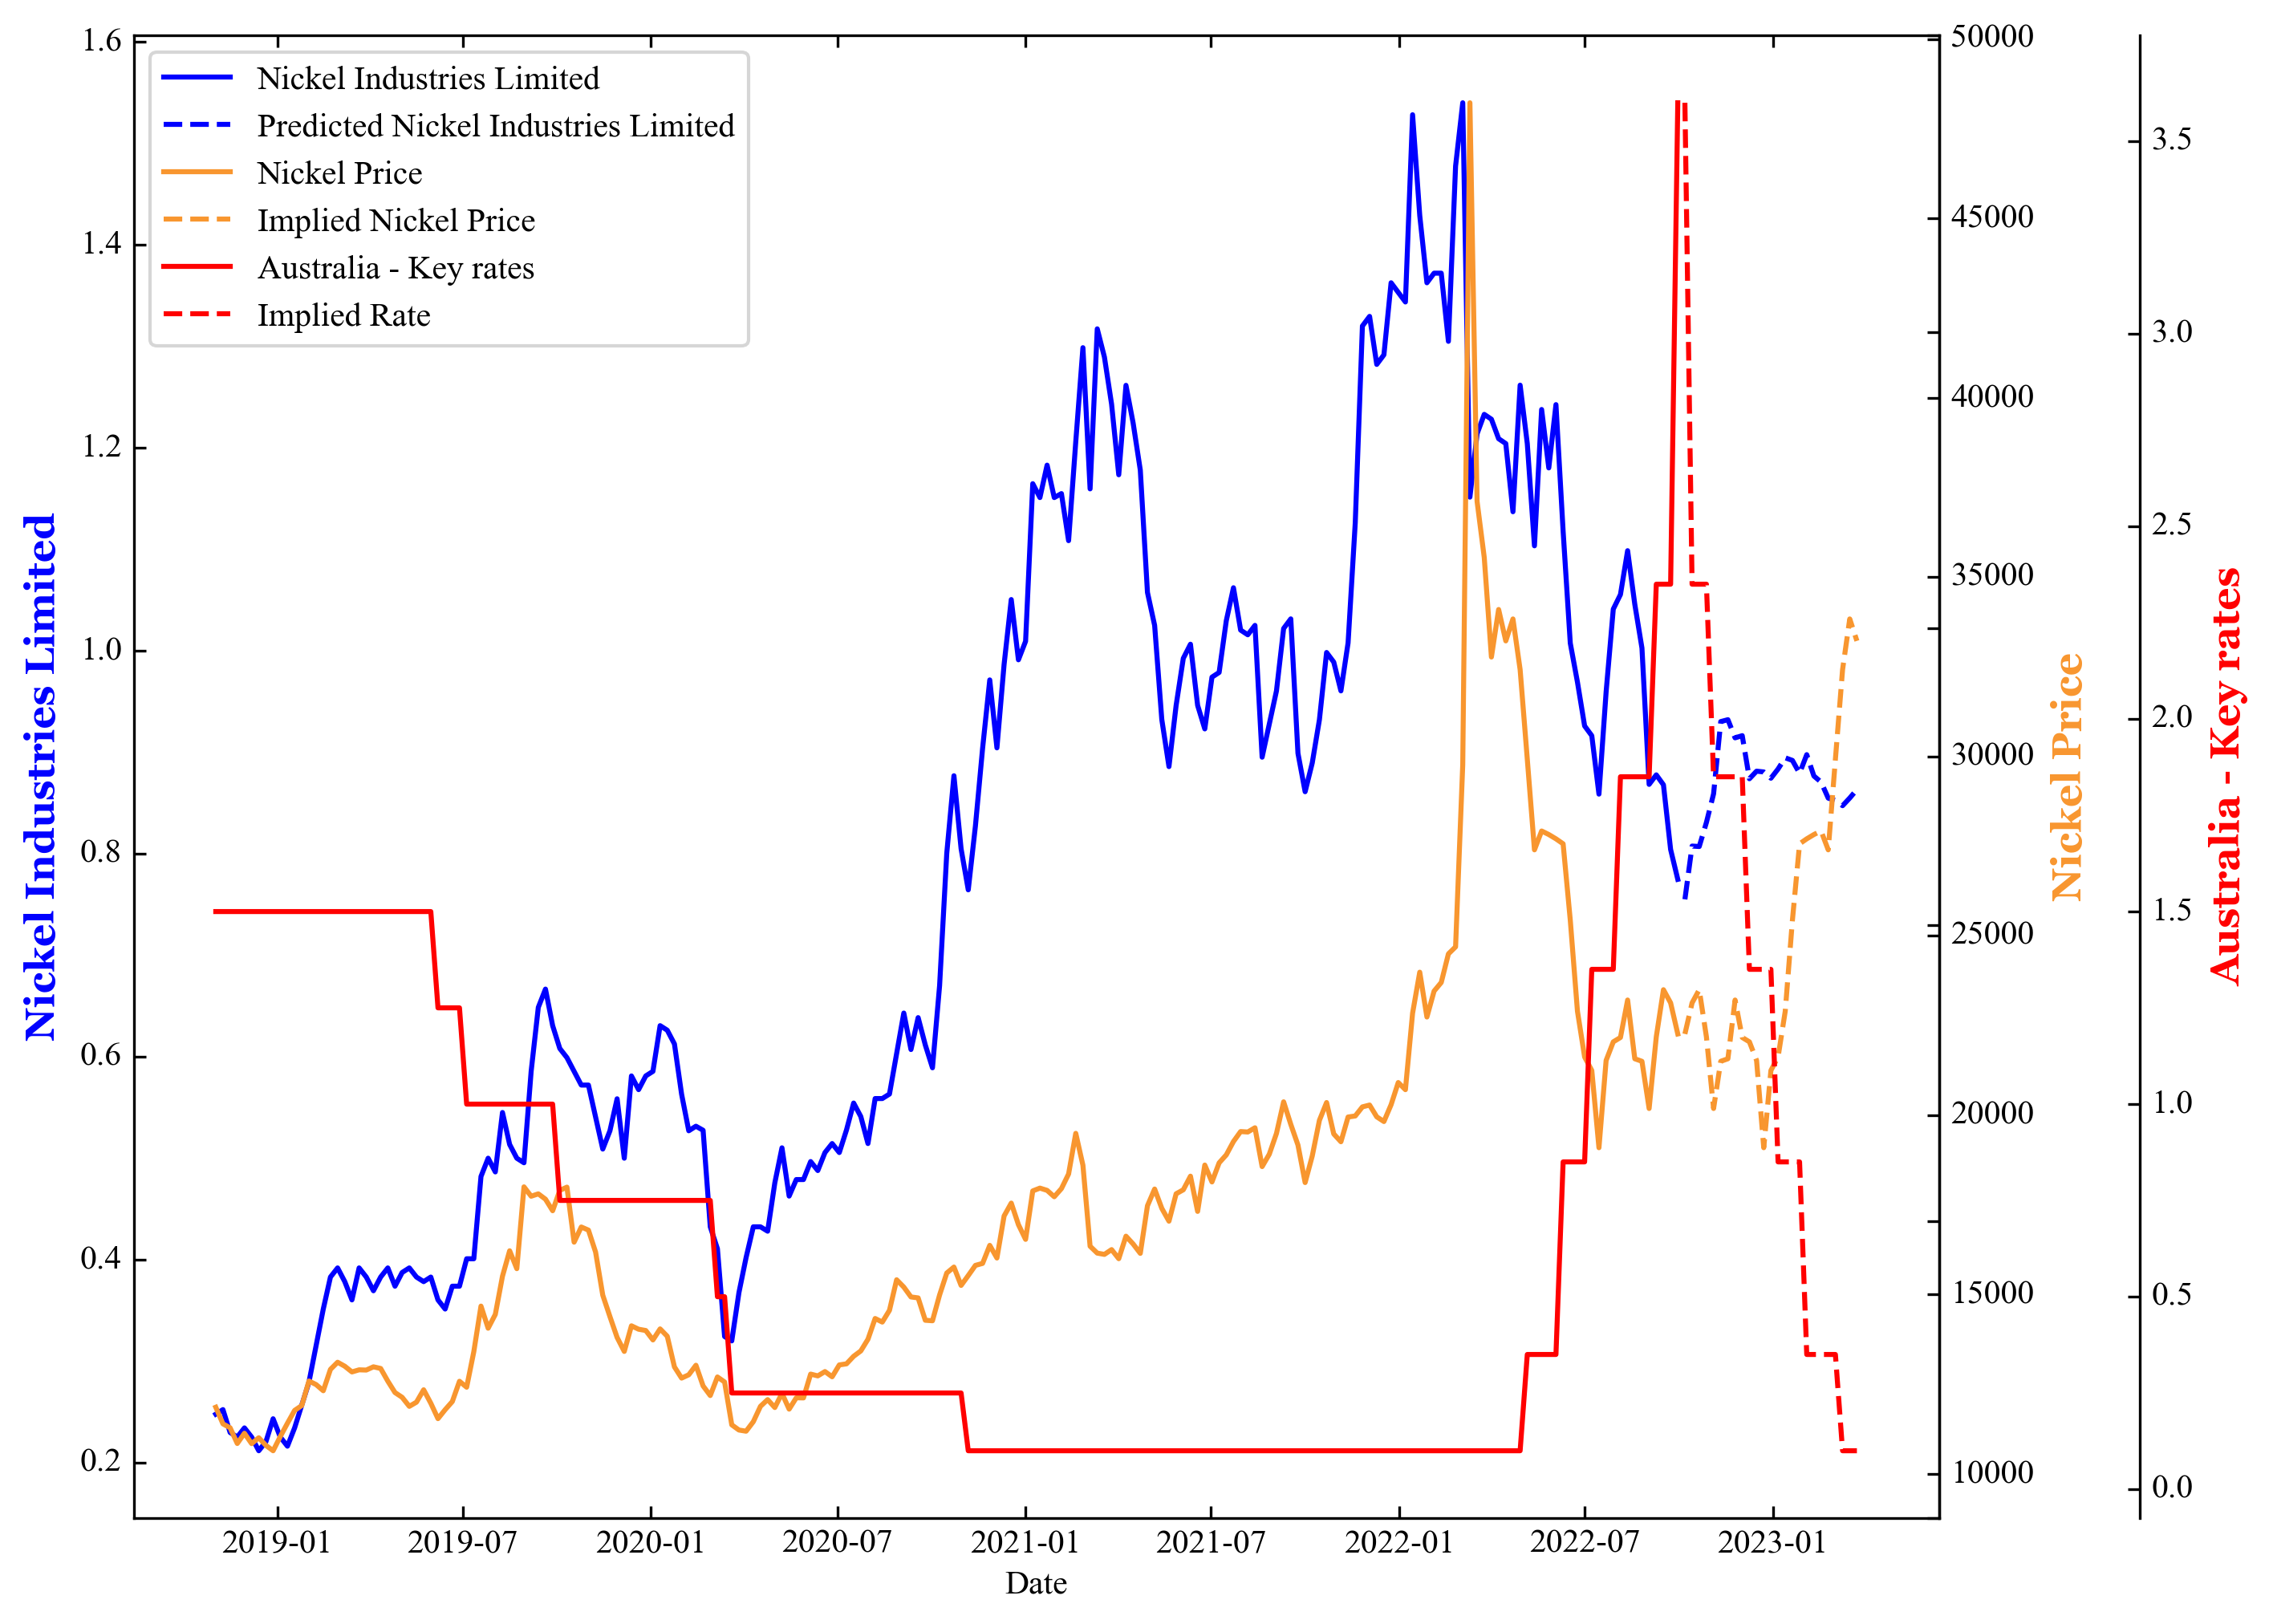

In [507]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
    
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

    
p1, = host.plot(data.index, data['NIC'], label="Nickel Industries Limited", color="blue")
p2, = par1.plot(data.index, data['Nickle price'], label="Nickel Price", color="#f8962f")
p3, = par2.plot(data.index, data['Rate'], label="Australia - Key rates", color="red")

host.plot(positive_predicted_value.index, positive_predicted_value['mean'], linestyle='--', label="Predicted Nickel Industries Limited", color="blue")
par1.plot(positive_future_data.index, positive_future_data['Nickle price'], linestyle='--', label="Implied Nickel Price", color="#f8962f")
par2.plot(positive_future_data.index, positive_future_data['Rate'], linestyle='--', label="Implied Rate", color="red")
    
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Nickel Industries Limited")
par1.set_ylabel("Nickel Price")
par2.set_ylabel("Australia - Key rates")
    
host.legend()
    
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
    
host.axis["left"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par1.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par2.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
    
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.set_dpi(300)

plt.savefig('images/positive.png', dpi=300)

plt.show()

In [418]:
len(pd.date_range(start='2022-10-01', end='2023-03-24', tz='Australia/Sydney', freq="W-FRI"))

25

In [464]:
len(np.union1d(33224.0, data['Nickle price']['2019-10-12':'2020-03-29'].values)[::-1])

25

In [431]:
data['Nickle price']['2022-04-12':].head()

Date
2022-04-15 00:00:00+10:00    33224.0
2022-04-22 00:00:00+10:00    33836.5
2022-04-29 00:00:00+10:00    32424.0
2022-05-06 00:00:00+10:00    29927.5
2022-05-13 00:00:00+10:00    27399.0
Freq: W-FRI, Name: Nickle price, dtype: float64

In [441]:
np.union1d(33224.0, data['Nickle price']['2019-10-12':'2020-03-29'].values)[::-1]

25

25

In [504]:
negative_future_data = pd.DataFrame(data={
    'Nickle price': np.union1d(22266.5, data['Nickle price']['2019-10-12':'2020-03-29'].values)[::-1],
    'Rate': np.array(range(25))*0+3.6, 
    'AUD/IDR': data['AUD/IDR']['2022-04-12':].values[::-1], 
    'NPI production': data['NPI production']['2022-04-12':].values[::-1], 
    'Mining': data['Mining']['2022-04-12':].values[::-1],
    'Metal products in indonesia': data['Metal products in indonesia']['2022-04-12':].values[::-1]
} , index=pd.date_range(start='2022-10-01', end='2023-03-24', tz='Australia/Sydney', freq="W-FRI"))

In [470]:
negative_future_data.describe()

,Nickle price,Rate,AUD/IDR,NPI production,Mining,Metal products in indonesia
count,25.000000,25.0,25.000000,25.000000,25.000000,25.000000
mean,14117.180000,3.6,10286.729297,43835.813333,233779.946667,1387.817600
std,2290.240534,0.0,189.425562,5247.599015,57609.690911,130.486736
min,11225.000000,3.6,9890.727539,38035.333333,199863.333333,1229.780000
25%,12704.000000,3.6,10149.545898,38035.333333,199863.333333,1229.780000
50%,13806.500000,3.6,10310.110352,48393.333333,205722.000000,1400.810000
75%,14386.500000,3.6,10386.610352,48393.333333,205722.000000,1471.160000
max,22266.500000,3.6,10669.565430,48393.333333,339672.000000,1568.340000


In [505]:
negative_predicted_value = last_res.get_prediction(
    negative_future_data.index[0], 
    negative_future_data.index[-1], 
    exog=negative_future_data[exog]
).summary_frame()

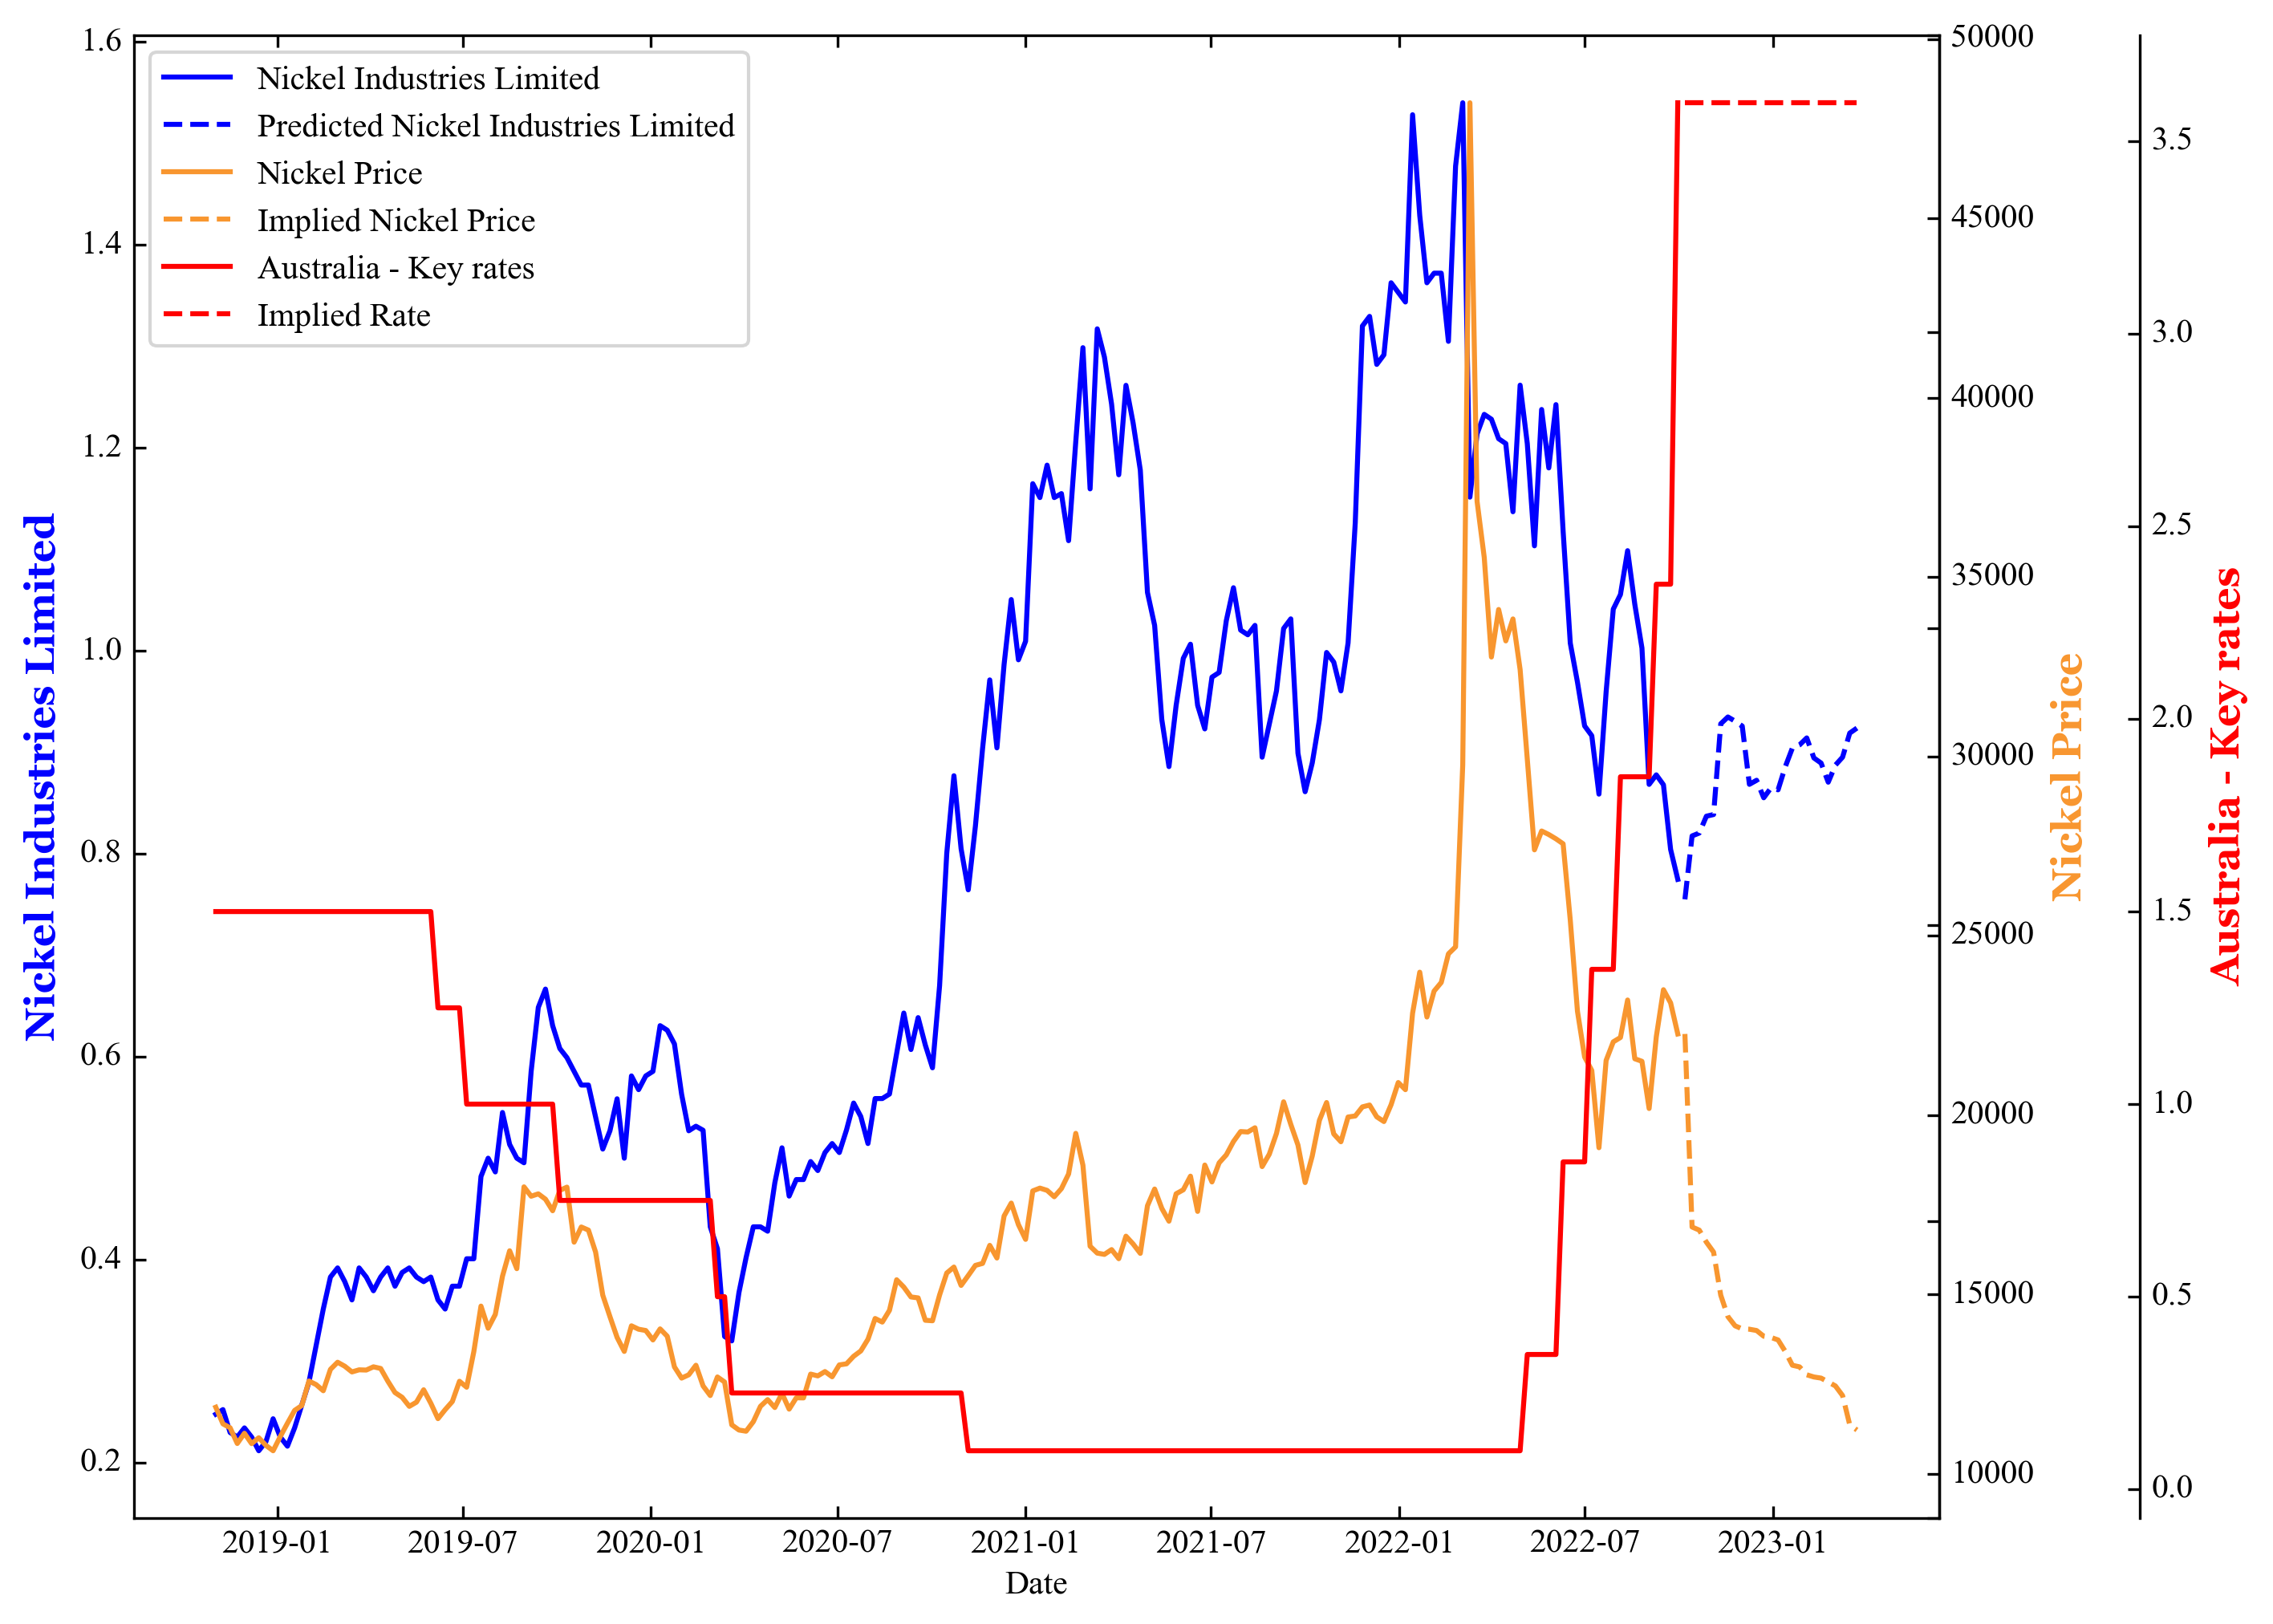

In [508]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.family':"Times New Roman"})

host = host_subplot(111, axes_class=axisartist.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()

par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
    
par1.axis["right"].toggle(all=True)
par2.axis["right"].toggle(all=True)

    
p1, = host.plot(data.index, data['NIC'], label="Nickel Industries Limited", color="blue")
p2, = par1.plot(data.index, data['Nickle price'], label="Nickel Price", color="#f8962f")
p3, = par2.plot(data.index, data['Rate'], label="Australia - Key rates", color="red")

host.plot(negative_predicted_value.index, negative_predicted_value['mean'], linestyle='--', label="Predicted Nickel Industries Limited", color="blue")
par1.plot(negative_future_data.index, negative_future_data['Nickle price'], linestyle='--', label="Implied Nickel Price", color="#f8962f")
par2.plot(negative_future_data.index, negative_future_data['Rate'], linestyle='--', label="Implied Rate", color="red")
    
host.set_xlabel("Date", fontsize=12)
host.set_ylabel("Nickel Industries Limited")
par1.set_ylabel("Nickel Price")
par2.set_ylabel("Australia - Key rates")
    
host.legend()
    
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
    
host.axis["left"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par1.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
par2.axis["right"].label.set(fontsize=12, fontweight='bold', fontfamily="Georgia")
    
fig = plt.gcf()
fig.set_size_inches(12, 8)
fig.set_dpi(300)

plt.savefig('images/negative.png', dpi=300)

plt.show()